Source Material: https://alexlouden.com/posts/2016-computer-vision-on-strawberries.html

In [1]:
%matplotlib inline
import cv2
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
from __future__ import division

/Users/moorejar/Envs/jupyter-notebook/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [31]:
# Read in an image.
image = cv2.imread('./images/strawberry.jpg')
#image = cv2.imread('./images/strawberry_2.jpg')
image.shape

(675, 900, 3)

In [32]:
# Convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize to a third of the size
image = cv2.resize(image, None, fx=1/3, fy=1/3)

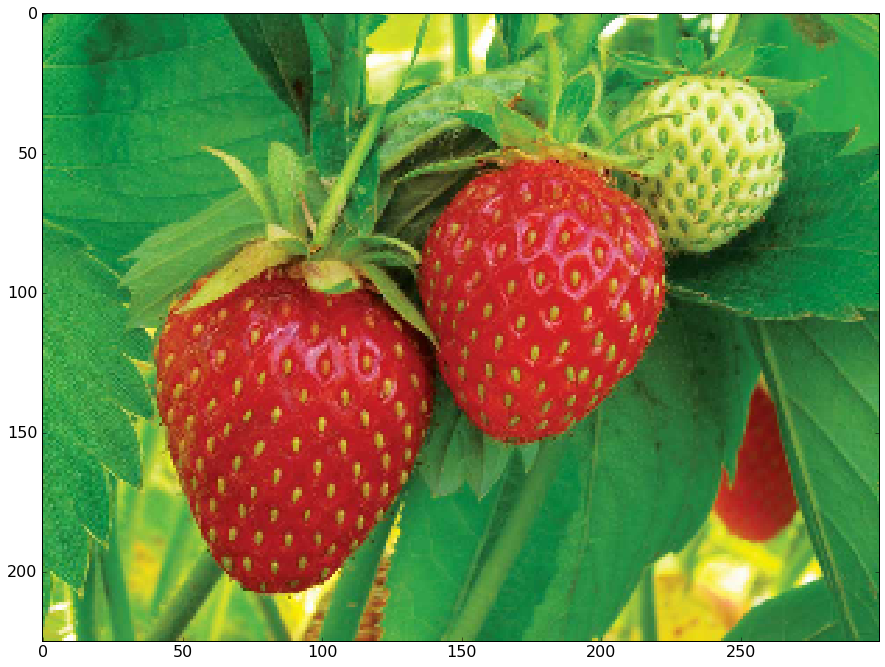

In [33]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(15, 15))

    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')

show(image)

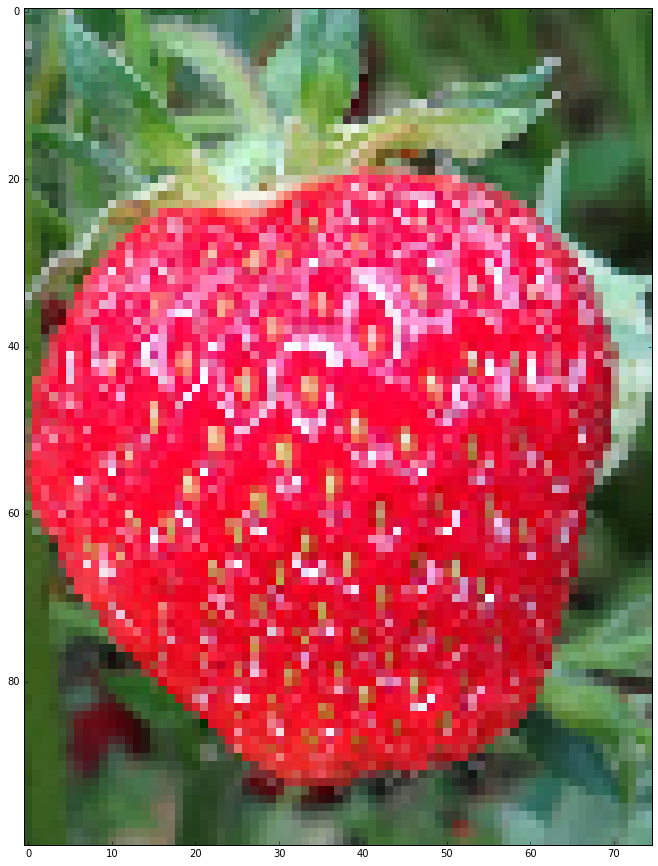

In [9]:
# We can crop the image however we want.  Let's slice out just the big red one.
image_cropped = image[25:125, 100:175]
show(image_cropped)

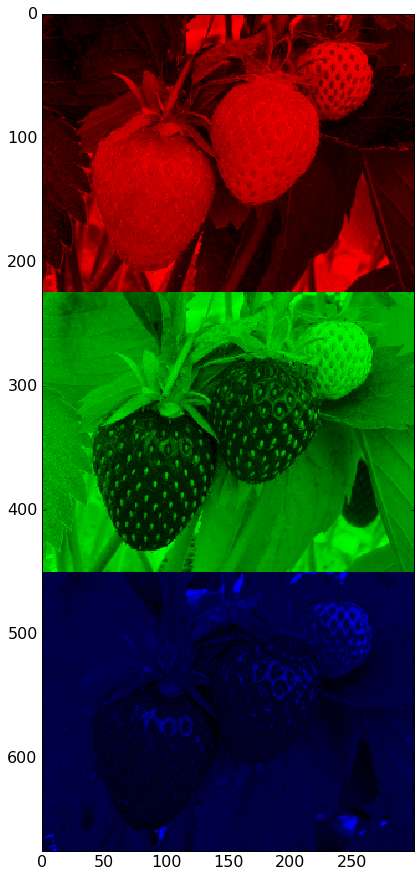

In [34]:
# Show Red/Green/Blue
images = []
for i in [0, 1, 2]:
    colour = image.copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 0
    if i != 2: colour[:,:,2] = 0
    images.append(colour)

show(np.vstack(images))

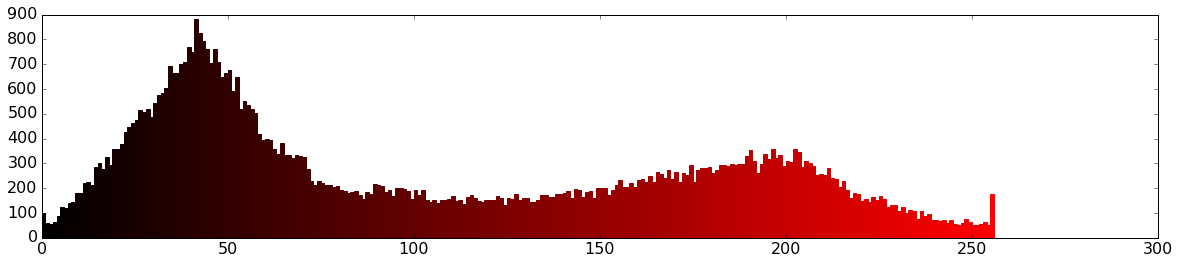

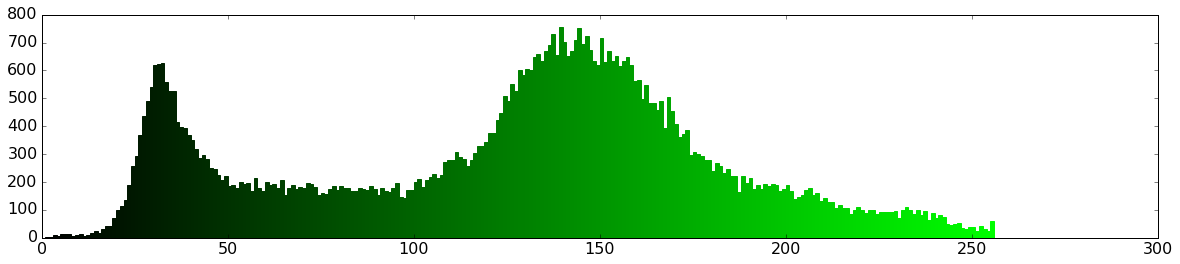

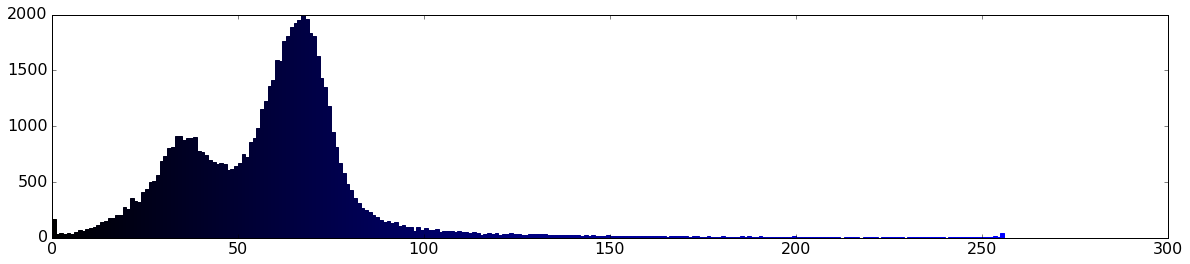

In [35]:
def show_rgb_hist(image):
    colours = ('r','g','b')
    for i, c in enumerate(colours):
        plt.figure(figsize=(20, 4))
        histr = cv2.calcHist([image], [i], None, [256], [0, 256])

        if c == 'r': colours = [((i/256, 0, 0)) for i in range(0, 256)]
        if c == 'g': colours = [((0, i/256, 0)) for i in range(0, 256)]
        if c == 'b': colours = [((0, 0, i/256)) for i in range(0, 256)]

        plt.bar(range(0, 256), histr, color=colours, edgecolor=colours, width=1)

        plt.show()

show_rgb_hist(image)

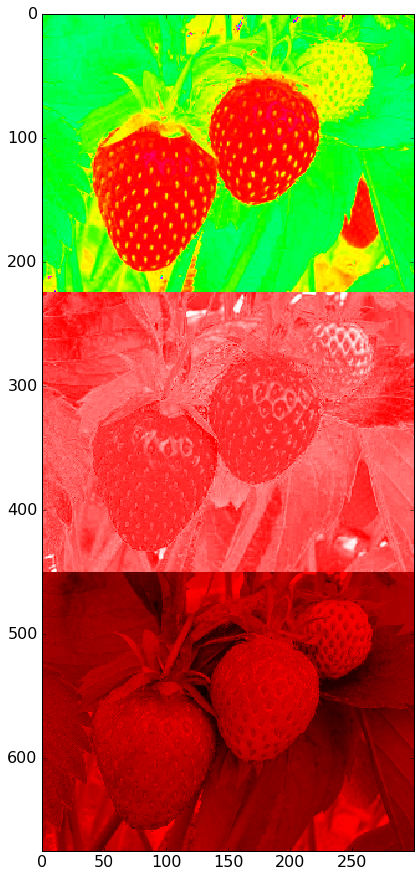

In [36]:
# Convert from RGB to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

images = []
for i in [0, 1, 2]:
    colour = hsv.copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 255
    if i != 2: colour[:,:,2] = 255
    images.append(colour)

hsv_stack = np.vstack(images)
rgb_stack = cv2.cvtColor(hsv_stack, cv2.COLOR_HSV2RGB)
show(rgb_stack)

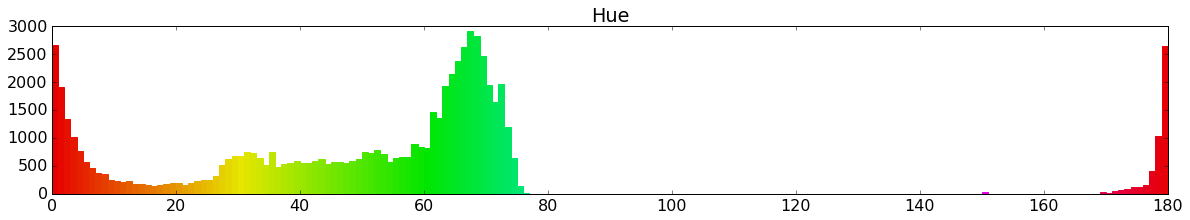

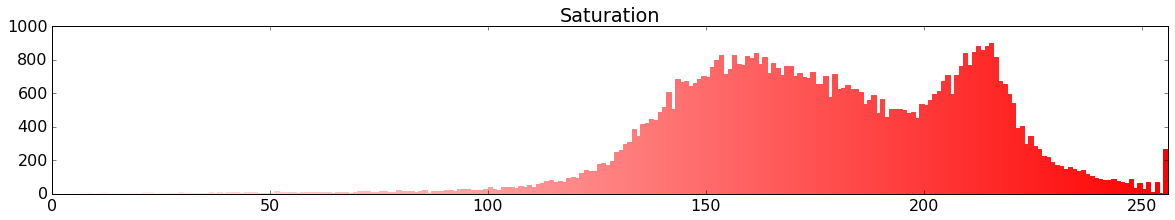

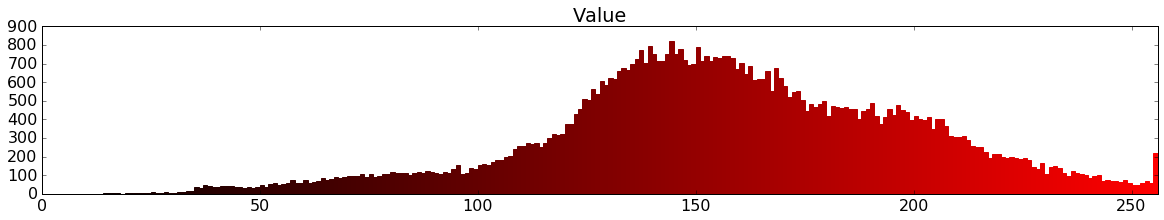

In [37]:
matplotlib.rcParams.update({'font.size': 16})

def show_hsv_hist(image):
    # Hue
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [0], None, [180], [0, 180])
    plt.xlim([0, 180])
    colours = [colors.hsv_to_rgb((i/180, 1, 0.9)) for i in range(0, 180)]
    plt.bar(range(0, 180), histr, color=colours, edgecolor=colours, width=1)
    plt.title('Hue')

    # Saturation
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [1], None, [256], [0, 256])
    plt.xlim([0, 256])

    colours = [colors.hsv_to_rgb((0, i/256, 1)) for i in range(0, 256)]
    plt.bar(range(0, 256), histr, color=colours, edgecolor=colours, width=1)
    plt.title('Saturation')

    # Value
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [2], None, [256], [0, 256])
    plt.xlim([0, 256])

    colours = [colors.hsv_to_rgb((0, 1, i/256)) for i in range(0, 256)]
    plt.bar(range(0, 256), histr, color=colours, edgecolor=colours, width=1)
    plt.title('Value')

show_hsv_hist(hsv)

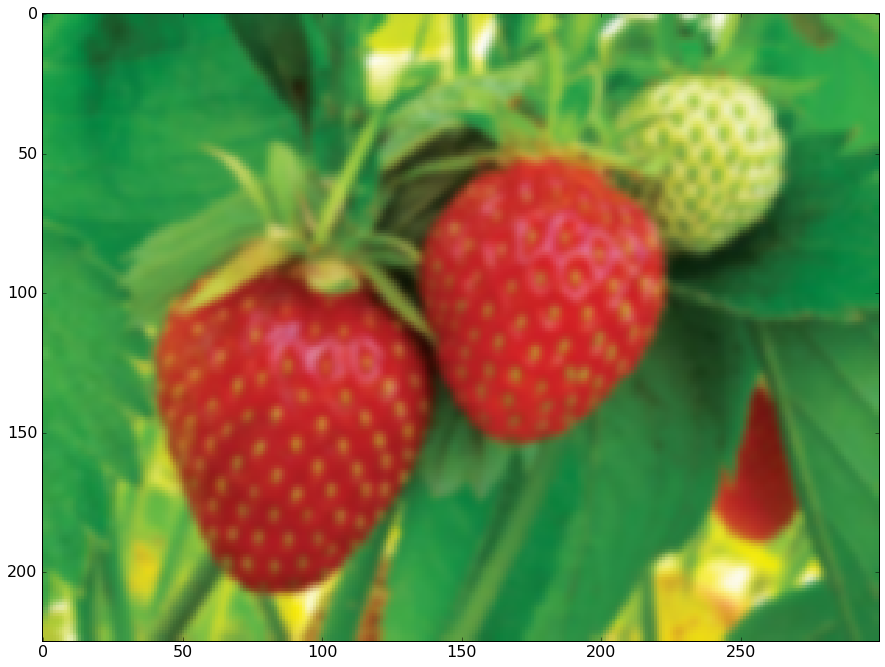

In [38]:
# Blur image slightly
image_blur = cv2.GaussianBlur(image, (7, 7), 0)
show(image_blur)

In [39]:
image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

# 0-10 hue
min_red = np.array([0, 100, 80])
max_red = np.array([10, 256, 256])
image_red1 = cv2.inRange(image_blur_hsv, min_red, max_red)

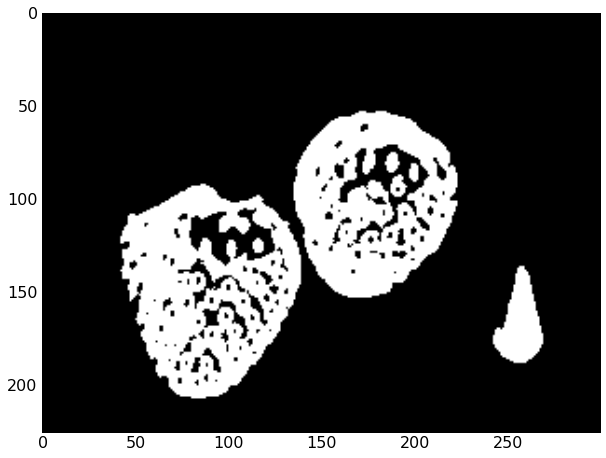

In [40]:
def show_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
show_mask(image_red1)

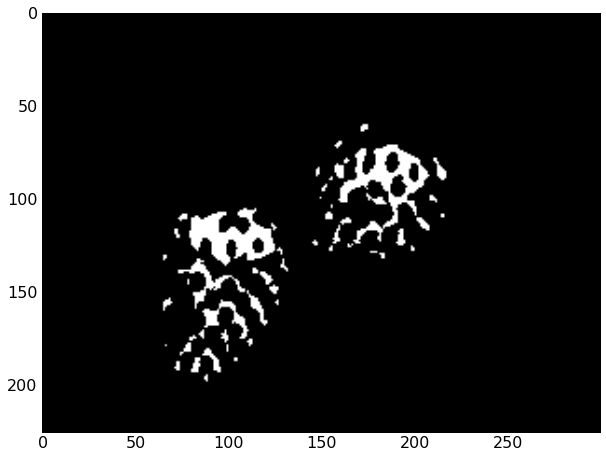

In [41]:
# 170-180 hue
min_red2 = np.array([170, 100, 80])
max_red2 = np.array([180, 256, 256])
image_red2 = cv2.inRange(image_blur_hsv, min_red2, max_red2)

show_mask(image_red2)

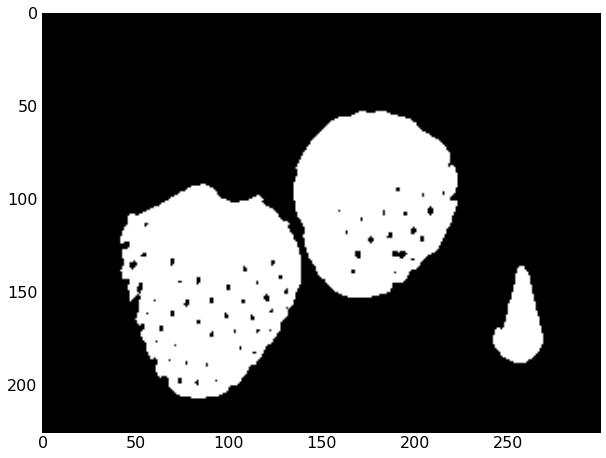

In [42]:
image_red = image_red1 + image_red2
show_mask(image_red)

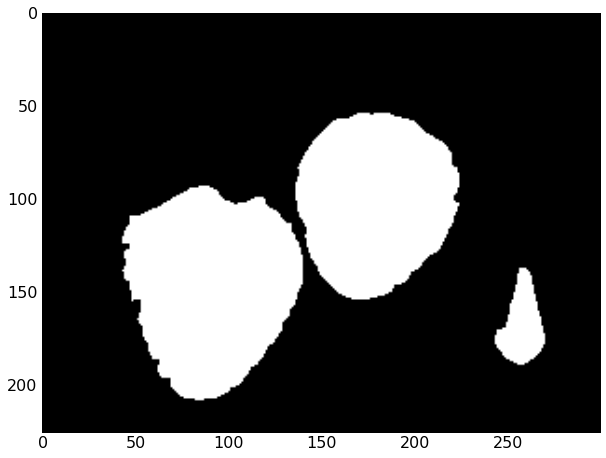

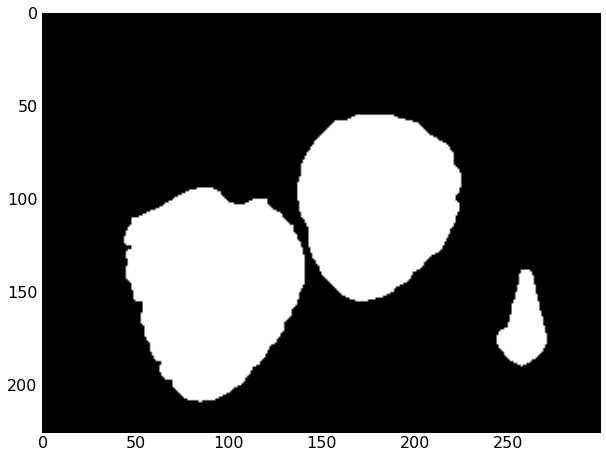

In [58]:
# Try 15 for the strawberry, 4 for the strawberries
tuning_morph = 4
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tuning_morph, tuning_morph))

# Fill small gaps
# Note: This might need to be tuned if there are more than one strawberry!
image_red_closed = cv2.morphologyEx(image_red, cv2.MORPH_CLOSE, kernel)
show_mask(image_red_closed)

# Remove specks
image_red_closed_then_opened = cv2.morphologyEx(image_red_closed, cv2.MORPH_OPEN, kernel)
show_mask(image_red_closed_then_opened)

3
3


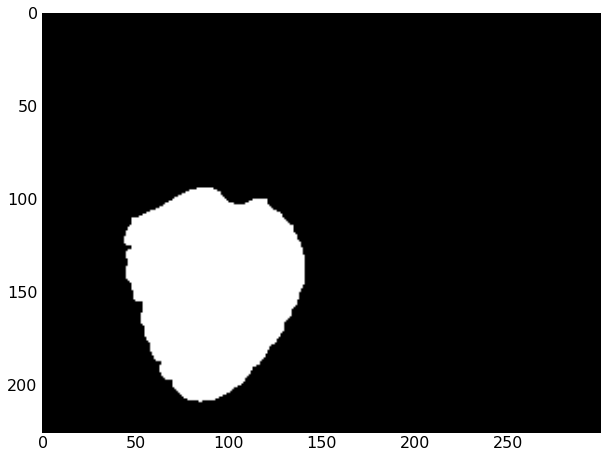

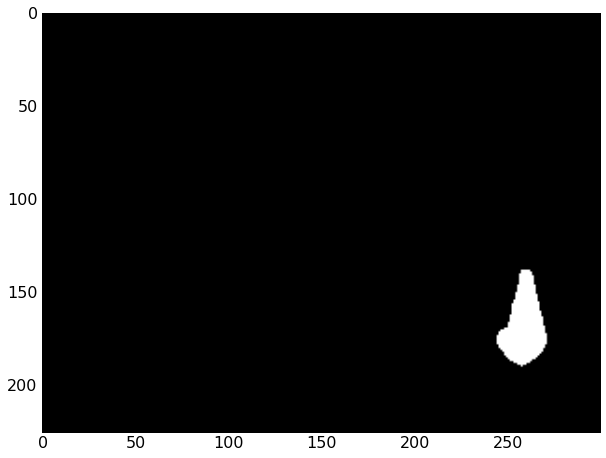

In [60]:
def find_biggest_contour(image):

    # Copy to prevent modification
    image = image.copy()
    print(len(cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)))
    other, contours, hierarchy= cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    biggest_contour = max(contours, key=cv2.contourArea)

    # Draw just largest contour
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask

def find_smallest_contour(image):

    # Copy to prevent modification
    image = image.copy()
    print(len(cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)))
    other, contours, hierarchy= cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    smallest_contour = min(contours, key=cv2.contourArea)

    # Draw just largest contour
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [smallest_contour], -1, 255, -1)
    return smallest_contour, mask


big_contour, mask = find_biggest_contour(image_red_closed_then_opened)
show_mask(mask)

small_contour, small_mask = find_smallest_contour(image_red_closed_then_opened)
show_mask(small_mask)

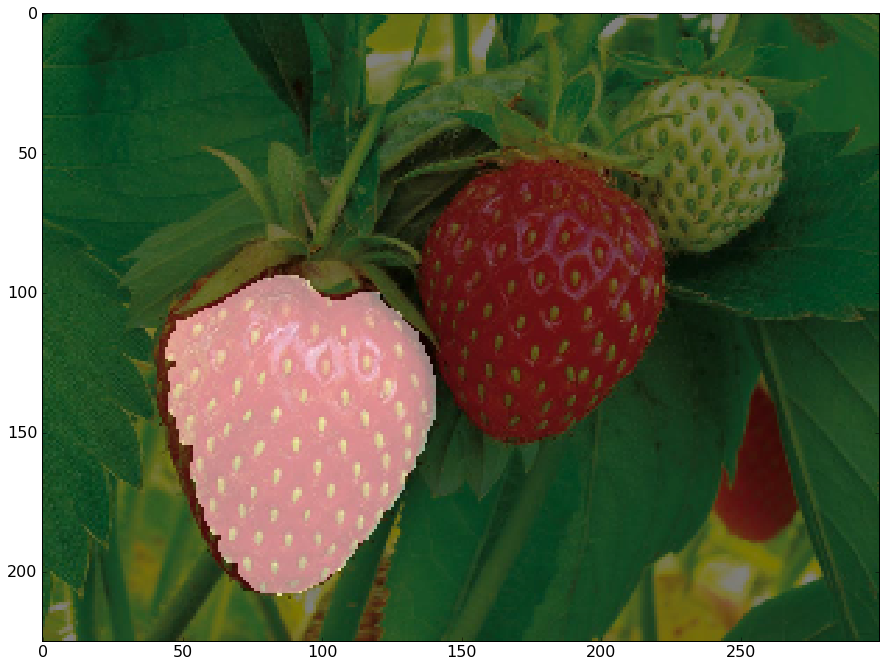

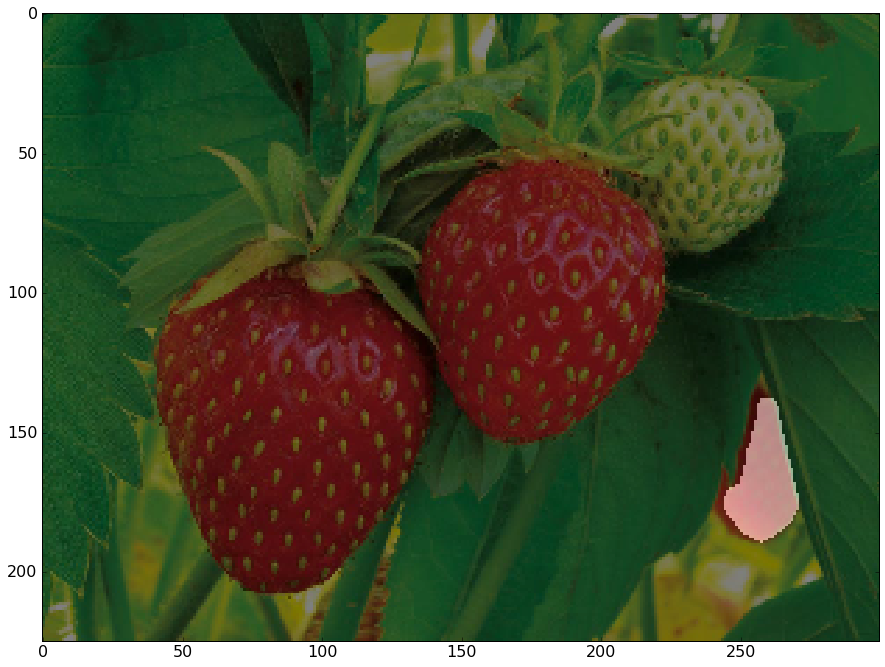

In [61]:
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    show(img)

overlay_mask(mask, image)
overlay_mask(small_mask, image)

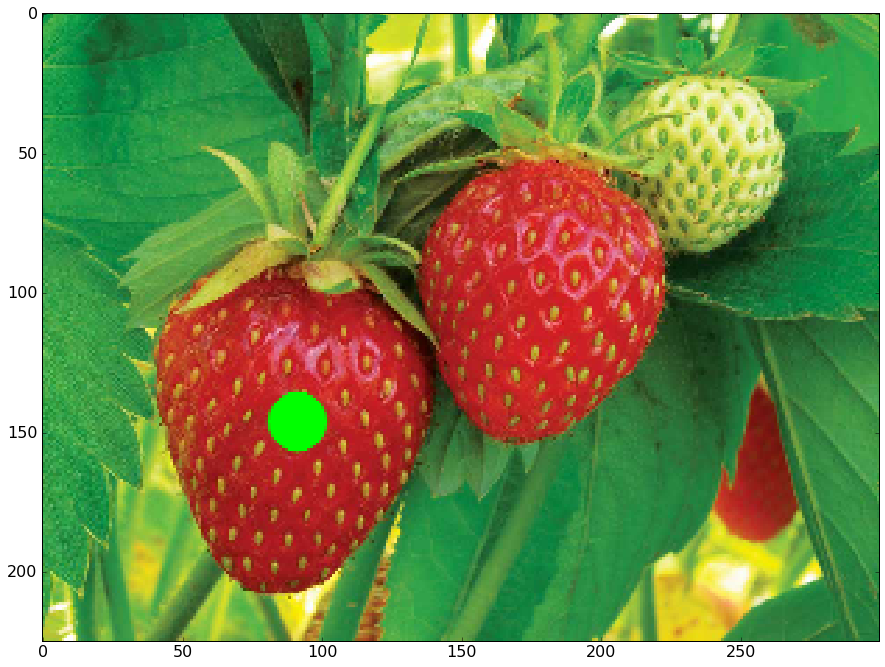

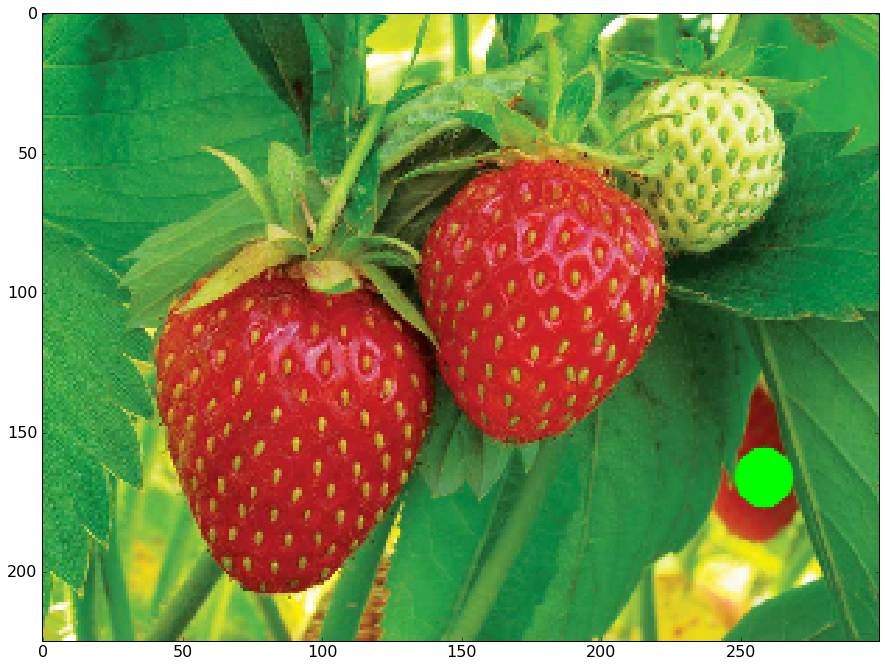

In [62]:
# Centre of mass
moments = cv2.moments(mask)
centre_of_mass = (
    int(moments['m10'] / moments['m00']),
    int(moments['m01'] / moments['m00'])
)
image_with_com = image.copy()
cv2.circle(image_with_com, centre_of_mass, 10, (0, 255, 0), -1, cv2.LINE_AA)
show(image_with_com)

# Centre of mass for smallest mask
moments = cv2.moments(small_mask)
centre_of_mass = (
    int(moments['m10'] / moments['m00']),
    int(moments['m01'] / moments['m00'])
)
small_image_with_com = image.copy()
cv2.circle(small_image_with_com, centre_of_mass, 10, (0, 255, 0), -1, cv2.LINE_AA)
show(small_image_with_com)

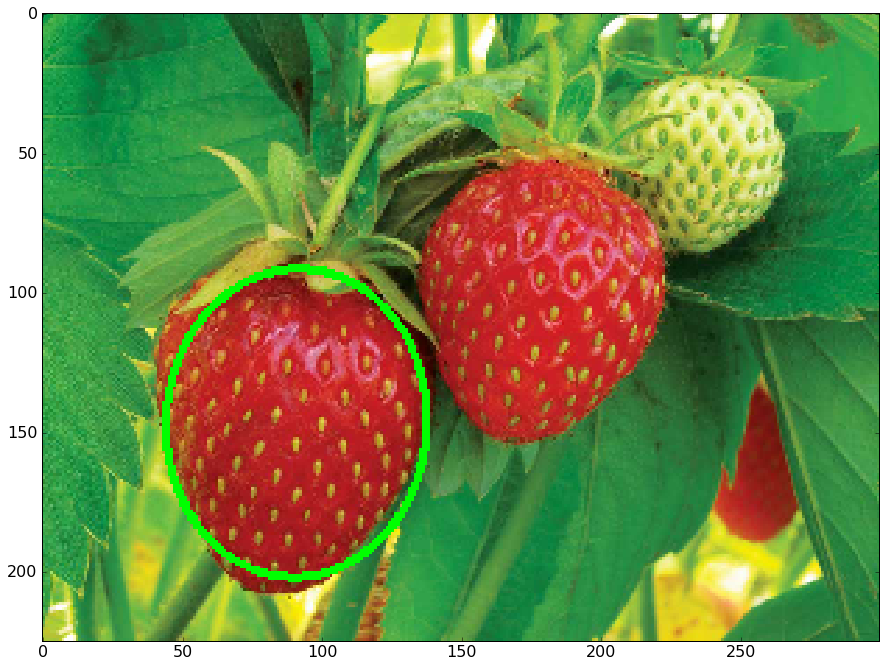

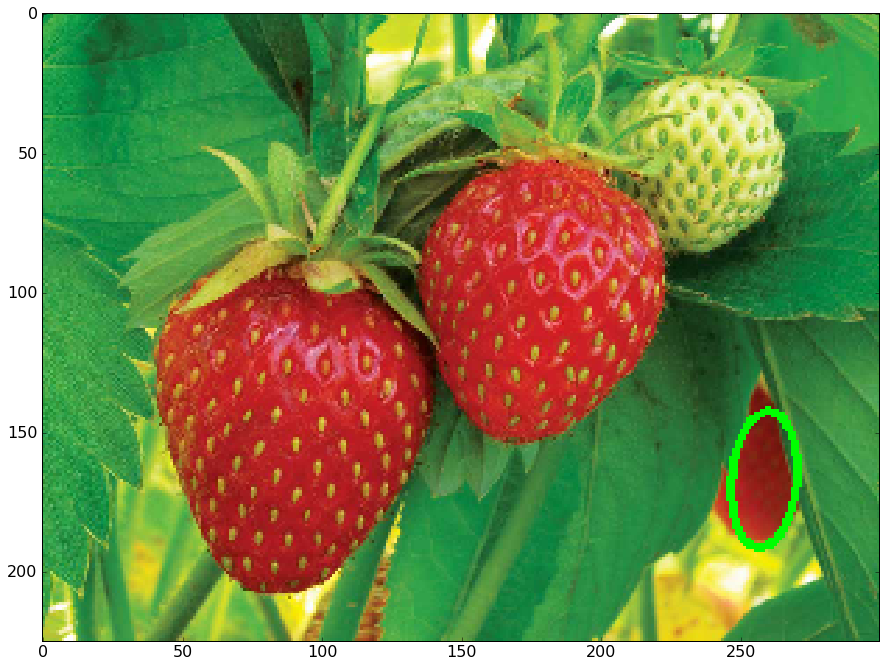

In [64]:
# Bounding ellipse
image_with_ellipse = image.copy()
ellipse = cv2.fitEllipse(big_contour)
cv2.ellipse(image_with_ellipse, ellipse, (0, 255, 0), 2)
show(image_with_ellipse)

small_image_with_ellipse = image.copy()
small_ellipse = cv2.fitEllipse(small_contour)
cv2.ellipse(small_image_with_ellipse, small_ellipse, (0, 255, 0), 2)
show(small_image_with_ellipse)